In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

### Parameters and Model

The Aphasia MPT model is depicted in the following figure:

<img src="aphasia_mpt.png" width=65% height=65% />


The table below lists the four types of responses (categories):


| Response (Category) | Description  | Probability |
| --- | --- | --- |
| C | The response matches the target. Ex: Cat | $a\times b\times c\times d\times e\times f$ |
| S | The response is a word with only a semantic relation to the target. Ex: Dog | $a\times b\times (1-c)\times f$ |
| F | The response is a word with only a phonological relation to the target. Ex: Hat | $a\times b\times c\times(g-f\times g +f-f\times d)$ |
| M | The response is a word with both a semantic and phonological relation the target. Ex: Rat| $a\times b\times c\times d\times(1-e)\times f$ |
| U | The response is a word with neither a semantic nor a phonological relation to the target. Ex: Fog | $a\times((1-f)\times(h-b\times c\times h)+f\times(1-b))$ |
| N | The response is not a word, but it has a phonological relation to the target. Ex: Cag | $a\times b\times c\times(-g-f+f\times g+1)$ |
| AN | The response is not a word, nor does it have a phonological relation to the target. Ex: Rog | $a\times((1-f)\times(1-h)\times(1-b\times c))$ |
| NA | All other responsess. |$1-a$  |

In [16]:
mpt_model_code = """
data {
  int<lower=1> N; // Number of trials
  int<lower=1> K; // Number of categories
  array[K] int<lower=0, upper=N> freqs;
}

parameters {
  real<lower = 0, upper=1> a;
  real<lower = 0, upper=1> b;
  real<lower = 0, upper=1> c;
  real<lower = 0, upper=1> d;
  real<lower = 0, upper=1> e;
  real<lower = 0, upper=1> f;
  real<lower = 0, upper=1> g;
  real<lower = 0, upper=1> h;
}

transformed parameters {
  // Model equations go here
  // Prob. Correct
  // Prob. Semantic
  // Prob. Formal
  // Prob. Mixed
  // Prob. Unrelated
  // Prob. Neologism
  // Prob. Absolute Neologism
  // Prob. Nonnaming Attempt
  simplex[8] theta;
  theta[1] = a*b*c*d*e*f;
  theta[2] = a*b*(1-c)*f;
  theta[3] = a*b*c*(g-f*g+f-f*d);
  theta[4] = a*b*c*d*(1-e)*f;
  theta[5] = a * ((1-f)*(h-b*c*h)+f*(1-b));
  theta[6] = a*b*c*(1-g-f+f*g);
  theta[7] = a*((1-f)*(1-h)*(1-b*c));
  theta[8] = 1-a;
}

model {
  target+=beta_lpdf(a| 1,1);
  target+=beta_lpdf(b| 1,1);
  target+=beta_lpdf(c| 1,1);
  target+=beta_lpdf(d| 1,1);
  target+=beta_lpdf(e| 1,1);
  target+=beta_lpdf(f| 1,1);
  target+=beta_lpdf(g| 1,1);
  target+=beta_lpdf(h| 1,1);
  target+=multinomial_lpmf(freqs | theta);
}

generated quantities{
  array[K] int pred_freqs;
  pred_freqs = multinomial_rng(theta, N);
}
"""

In [17]:
data=[45404, 240, 514, 35, 1419, 4043, 991, 11229]
sum = 0
for i in data:
    sum+=i

In [18]:
### Compile, fit, and diagnose model
### Your code here
stan_dict = {
    'freqs': data,
    'N': sum,
    'K': 8
}

# Compile model
posterior = stan.build(mpt_model_code, data=stan_dict, random_seed=42)


# Sample (i.e., inverse inference)
fit = posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 

Building: 26.5s, done.
Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_wwjzccm7_namespace::log_prob: theta is not a valid simplex. theta[6] = -8.79138e-50, but should be greater than or equal to 0 (in '/tmp/httpstan_v4cuo46r/model_wwjzccm7.stan', line 29, column 2 to column 19)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 

In [19]:
### Parameter recovery and predictions
# Estimation summary, convergence, and efficiency diagnostics
az.summary(fit)

/home/carrc4/.local/lib/python3.8/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.824,0.002,0.821,0.827,0.000,0.000,14795.0,7409.0,1.0
b,0.957,0.001,0.955,0.959,0.000,0.000,13349.0,7153.0,1.0
c,0.992,0.000,0.991,0.993,0.000,0.000,13296.0,7034.0,1.0
d,1.000,0.000,1.000,1.000,0.000,0.000,8690.0,4659.0,1.0
e,0.999,0.000,0.999,0.999,0.000,0.000,14012.0,7331.0,1.0
f,0.895,0.001,0.892,0.897,0.000,0.000,16477.0,6978.0,1.0
g,0.112,0.005,0.103,0.121,0.000,0.000,12475.0,7518.0,1.0
h,0.001,0.001,0.000,0.003,0.000,0.000,9585.0,5340.0,1.0
theta[0],0.700,0.002,0.696,0.703,0.000,0.000,15934.0,7531.0,1.0
theta[1],0.005,0.000,0.005,0.006,0.000,0.000,13182.0,6878.0,1.0


/home/carrc4/.local/lib/python3.8/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


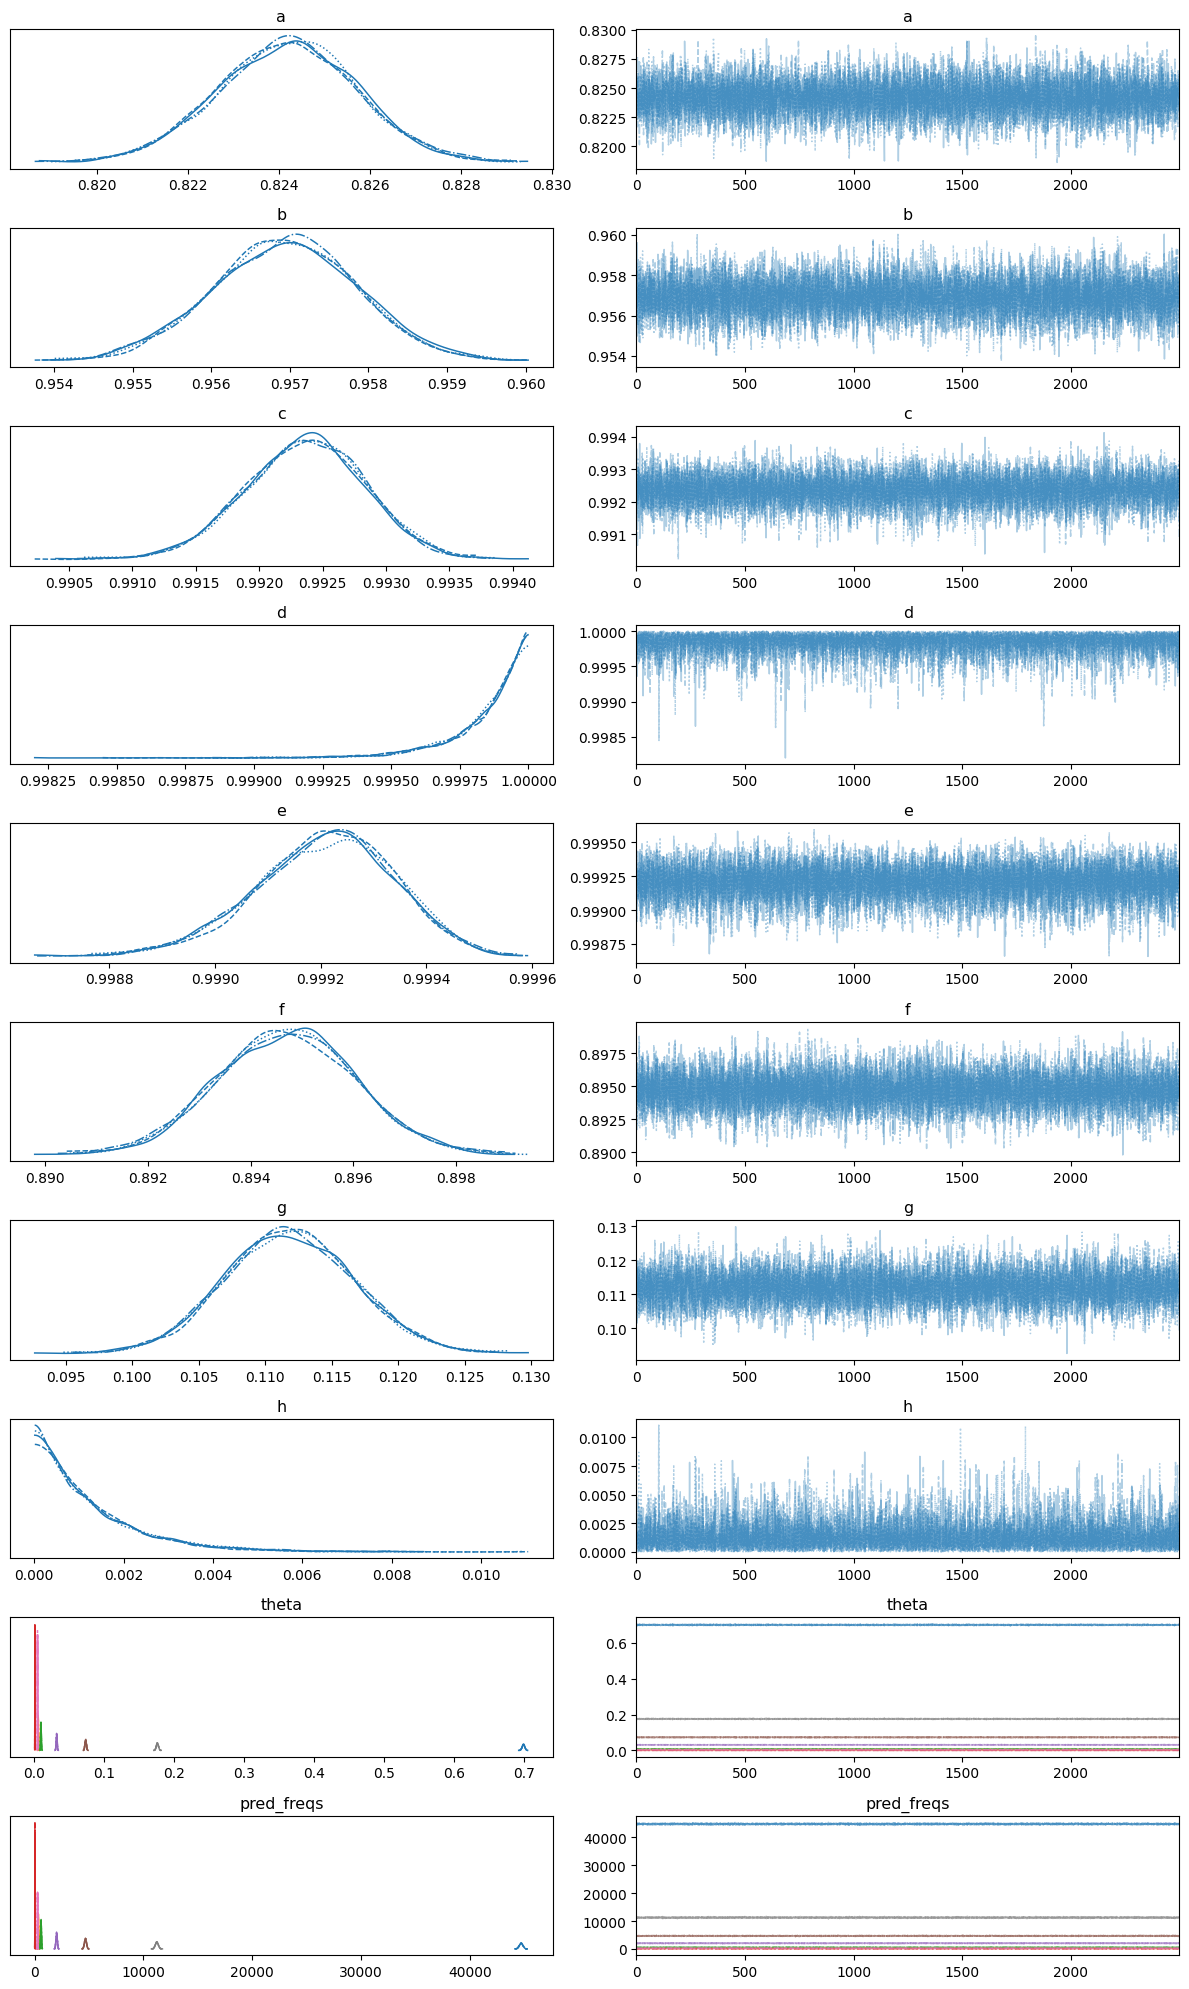

In [20]:
# Traceplots and marginals - visual convergence checks
azarr = az.plot_trace(fit)
plt.tight_layout()